In [ ]:
# !wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh

# !chmod +x Anaconda3-5.1.0-Linux-x86_64.sh

# !bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

In [ ]:
# !conda update -n base -c defaults conda -y

In [ ]:
# !git clone https://github.com/alibaba/EasyNLP.git
# %cd EasyNLP/diffusion/FreePromptEditing/

In [ ]:
# !conda env create -f environment.yaml

In [ ]:
# !source activate FPE

In [2]:
# !pip install diffusers
# !pip install einops

device(type='cpu')

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from diffusers import DDIMScheduler

from Freeprompt.diffuser_utils import FreePromptPipeline
from Freeprompt.freeprompt_utils import register_attention_control_new
from torchvision.utils import save_image
from torchvision.io import read_image
from Freeprompt.freeprompt import SelfAttentionControlEdit,AttentionStore


#### Model Construction

In [2]:
# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_path = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = FreePromptPipeline.from_pretrained(model_path, scheduler=scheduler).to(device)
device

text_encoder/pytorch_model.fp16.safetensors not found


Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

/home/novikova/opt/i55/diff/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:101: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.11.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)


device(type='cuda')

#### Real editing

In [14]:

# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(device)
    return image

self_replace_steps = .8
NUM_DIFFUSION_STEPS = 50

out_dir = "examples/outputs"


SOURCE_IMAGE_PATH = "examples/img/000141.jpg"
source_image = load_image(SOURCE_IMAGE_PATH, device)

source_prompt = ""

# invert the source image
start_code, latents_list = pipe.invert(source_image,
                                        source_prompt,
                                        guidance_scale=7.5,
                                        num_inference_steps=50,
                                        return_intermediates=True)

target_prompt = 'a green car'

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(prompts,
                    latents=start_code,
                    guidance_scale=7.5,
                    ref_intermediate_latents=latents_list)


save_image(results[1], os.path.join(out_dir, str(target_prompt)+'.jpg'))


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


In [4]:
# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_path = "runwayml/stable-diffusion-v1-5"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = FreePromptPipeline.from_pretrained(model_path, scheduler=scheduler).to(device)


text_encoder/pytorch_model.fp16.safetensors not found


Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

In [5]:

# Note that you may add your Hugging Face token to get access to the models
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(device)
    return image

self_replace_steps = .8
NUM_DIFFUSION_STEPS = 50

out_dir = "examples/outputs"


SOURCE_IMAGE_PATH = "examples/img/000141.jpg"
source_image = load_image(SOURCE_IMAGE_PATH, device)

source_prompt = ""

# invert the source image
start_code, latents_list = pipe.invert(source_image,
                                        source_prompt,
                                        guidance_scale=7.5,
                                        num_inference_steps=50,
                                        return_intermediates=True)

target_prompt = 'a purple bike'

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(prompts,
                    latents=start_code,
                    guidance_scale=7.5,
                    ref_intermediate_latents=latents_list)


save_image(results[1], os.path.join(out_dir, str(target_prompt)+'.jpg'))


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


In [6]:

target_prompt = 'a bike'

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(prompts,
                    latents=start_code,
                    guidance_scale=7.5,
                    ref_intermediate_latents=latents_list)


save_image(results[1], os.path.join(out_dir, str(target_prompt)+'.jpg'))

DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


In [7]:

SOURCE_IMAGE_PATH = "examples/img/chihuahua.jpg"
source_image = load_image(SOURCE_IMAGE_PATH, device)

source_prompt = ""

# invert the source image
start_code, latents_list = pipe.invert(source_image,
                                        source_prompt,
                                        guidance_scale=7.5,
                                        num_inference_steps=50,
                                        return_intermediates=True)

DDIM Inversion: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.64it/s]


In [8]:

target_prompt = 'chihuahua eating burger'

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(prompts,
                    latents=start_code,
                    guidance_scale=7.5,
                    ref_intermediate_latents=latents_list)


save_image(results[1], os.path.join(out_dir, str(target_prompt)+'.jpg'))

DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


In [9]:

target_prompt = 'cat eating ice cream'

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(prompts,
                    latents=start_code,
                    guidance_scale=7.5,
                    ref_intermediate_latents=latents_list)


save_image(results[1], os.path.join(out_dir, str(target_prompt)+'.jpg'))

DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


In [10]:

target_prompt = 'cat drinks a milkshake '

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(prompts,
                    latents=start_code,
                    guidance_scale=7.5,
                    ref_intermediate_latents=latents_list)


save_image(results[1], os.path.join(out_dir, str(target_prompt)+'.jpg'))

DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


In [11]:

target_prompt = 'chihuahua eating burger against a background of mountains'

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(prompts,
                    latents=start_code,
                    guidance_scale=7.5,
                    ref_intermediate_latents=latents_list)


save_image(results[1], os.path.join(out_dir, str(target_prompt)+'.jpg'))

DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


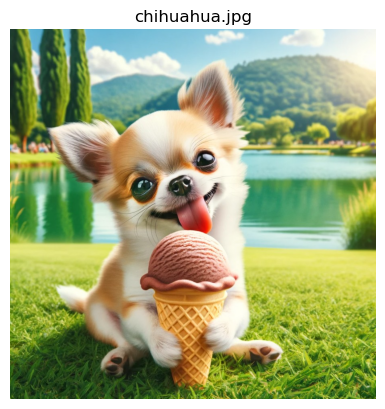

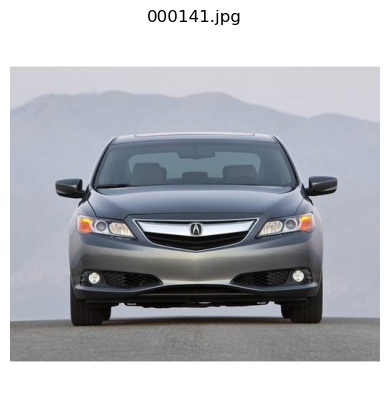

In [12]:
import os
import matplotlib.pyplot as plt
from PIL import Image

images_folder_path = 'examples/img/'

image_files = [f for f in os.listdir(images_folder_path) if os.path.isfile(os.path.join(images_folder_path, f))]

for image_file in image_files:
    image_path = os.path.join(images_folder_path, image_file)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')  # Hide axis
    plt.show()

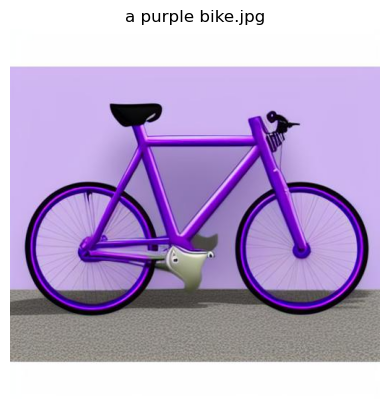

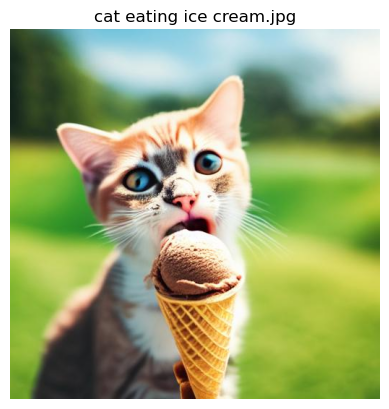

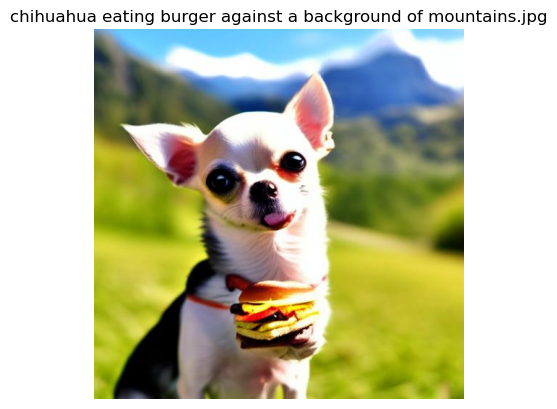

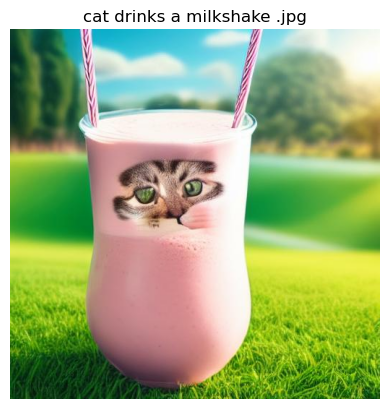

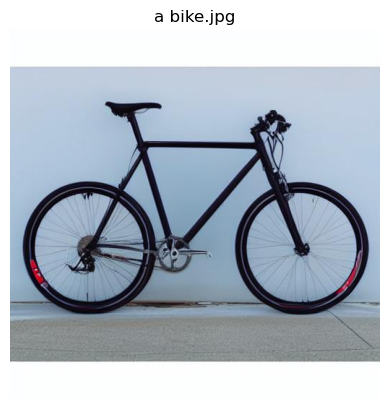

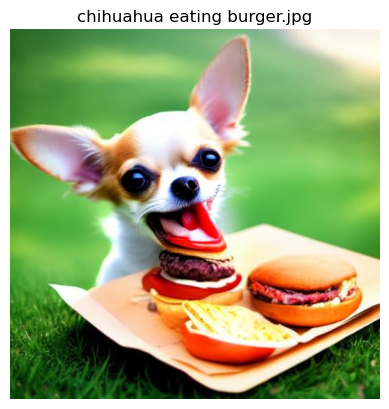

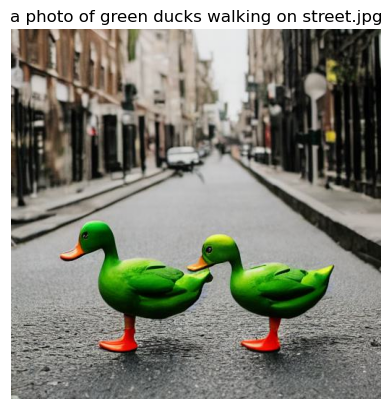

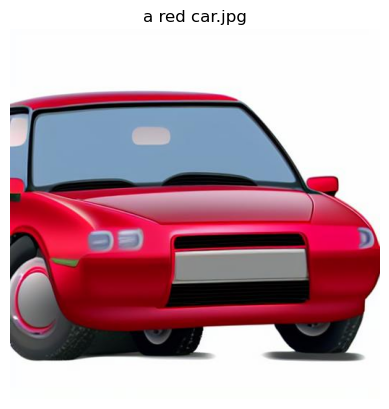

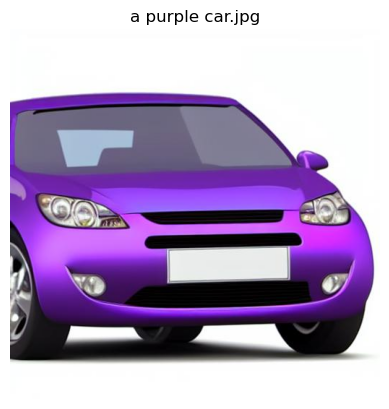

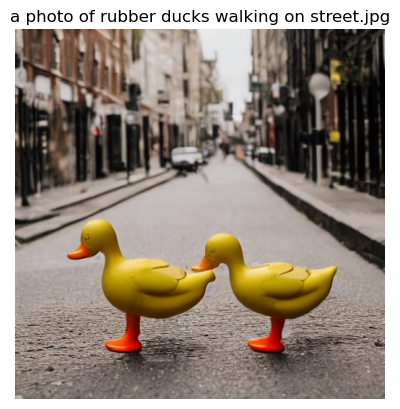

In [13]:
import os
import matplotlib.pyplot as plt
from PIL import Image

images_folder_path = 'examples/outputs/'

image_files = [f for f in os.listdir(images_folder_path) if os.path.isfile(os.path.join(images_folder_path, f))]

for image_file in image_files:
    image_path = os.path.join(images_folder_path, image_file)

    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')  # Hide axis
    plt.show()